In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from transformers import BertTokenizer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import os
import time
import math
import random
import matplotlib.pyplot as plt


In [ ]:
from traitlets.traitlets import validate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=512, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=512, shuffle=False, pin_memory=torch.cuda.is_available())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def show_plot(train_l, test_l, title):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.plot(range(len(train_l)), train_l, label="train")
    plt.plot(range(len(test_l)), test_l, label="test")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def calc_loss(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [ ]:
def calc_metrics(model):
    y_ = np.array([])
    y_model_ = np.array([])
    for X, y in iter(test_loader):        
        y_model = model(X.to(device)).max(dim=1)[1]
        y_ = np.concatenate((y_, y.data))
        y_model_ = np.concatenate((y_model_, y_model.data.cpu()))
    print(f'Precision score: {precision_score(y_, y_model_,average="macro")}')
    print(f'Recall score: {recall_score(y_, y_model_, average="macro")}')
    print(f'F1 score: {f1_score(y_, y_model_, average="macro")}')

In [ ]:
class CNN(nn.Module):
    def __init__(self, channels_cnt):
        super(CNN, self).__init__()
        self.channels_cnt = channels_cnt
        self.conv1 = nn.Conv2d(3, self.channels_cnt, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.channels_cnt)
        self.conv2 = nn.Conv2d(self.channels_cnt, self.channels_cnt*2, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.channels_cnt*2)
        self.conv3 = nn.Conv2d(self.channels_cnt*2, self.channels_cnt*4, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.channels_cnt*4)
        self.linear1 = nn.Linear(4*4*self.channels_cnt*4, self.channels_cnt*4)
        self.bn4 = nn.BatchNorm1d(self.channels_cnt*4)
        self.linear2 = nn.Linear(self.channels_cnt*4, 10)       

    def forward(self, x):
        x = self.bn1(self.conv1(x))                    # batch_sz x channels_cnt x 32 x 32
        x = F.relu(F.max_pool2d(x, 2))                 # batch_sz x channels_cnt x 16 x 16
        x = self.bn2(self.conv2(x))                    # batch_sz x channels_cnt*2 x 16 x 16
        x = F.relu(F.max_pool2d(x, 2))                 # batch_sz x channels_cnt*2 x 8 x 8
        x = self.bn3(self.conv3(x))                    # batch_sz x channels_cnt*3 x 8 x 8
        x = F.relu(F.max_pool2d(x, 2))                 # batch_sz x channels_cnt*4 x 4 x 4
        x = x.view(-1, self.channels_cnt*4*4*4)        # batch_sz x channels_cnt*4*4*4
        x = F.relu(self.bn4(self.linear1(x)))          # batch_sz x channels_cnt4
        x = self.linear2(x)                            # batch_sz x 10
        return x
    

In [ ]:
def train(model, epochs=40):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calc_loss(model(X), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calc_loss(model(X), y)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [ ]:
model_cnn_base = CNN(32).to(device)
train_l, test_l = train(model_cnn_base,epochs=5)

Epoch 0 | Train loss 1.252249250946045 | Test loss 0.956107089805603
Epoch 1 | Train loss 0.8270830268096924 | Test loss 0.825495337677002
Epoch 2 | Train loss 0.658554509601593 | Test loss 0.7502914518356323
Epoch 3 | Train loss 0.5332466827964782 | Test loss 0.7153903223991394
Epoch 4 | Train loss 0.43636679177284243 | Test loss 0.7185668144226074


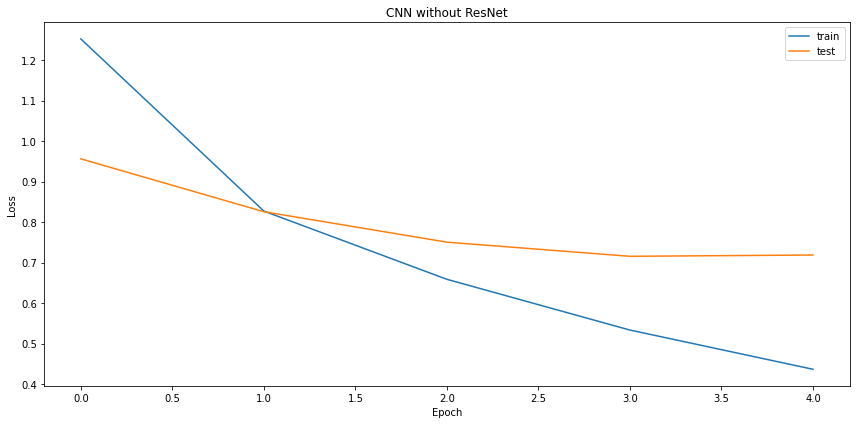

In [ ]:
show_plot(train_l, test_l, "CNN without ResNet")

In [ ]:
calc_metrics(model_cnn_base)

Precision score: 0.7542932210825405
Recall score: 0.7545
F1 score: 0.753942141638697


In [ ]:
# pretrained model from https://github.com/chenyaofo/pytorch-cifar-models
model_resnet_pretrained = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:
model_resnet_pretrained = model_resnet_pretrained.to(device)

In [ ]:
def calc_loss_kndist(outputs, outputs_teacher, labels, a=0.5):
    # fst = a * nn.CrossEntropyLoss()(outputs, labels)
    # snd = (1 - a) * nn.MSELoss()(torch.argmax(outputs_teacher, 1).values, labels)
    return nn.KLDivLoss()(F.log_softmax(outputs, dim=1),
                             F.softmax(outputs_teacher, dim=1)) * a + F.cross_entropy(outputs, labels) * (1. - a)

In [ ]:
def train(model, epochs=40, a_kd=0.5):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calc_loss_kndist(model(X), model_resnet_pretrained(X), y, a_kd)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calc_loss_kndist(model(X), model_resnet_pretrained(X), y, a_kd)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [ ]:
model_cnn_distillated = CNN(32).to(device)
train_l, test_l = train(model_cnn_distillated, epochs=5, a_kd=0.5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0 | Train loss 0.6645324537277222 | Test loss 0.508974287033081
Epoch 1 | Train loss 0.4454170866584778 | Test loss 0.44666361875534055
Epoch 2 | Train loss 0.3559934286785126 | Test loss 0.398869940328598
Epoch 3 | Train loss 0.29271134717941283 | Test loss 0.39442376699447634
Epoch 4 | Train loss 0.23994007732391356 | Test loss 0.38914213824272154


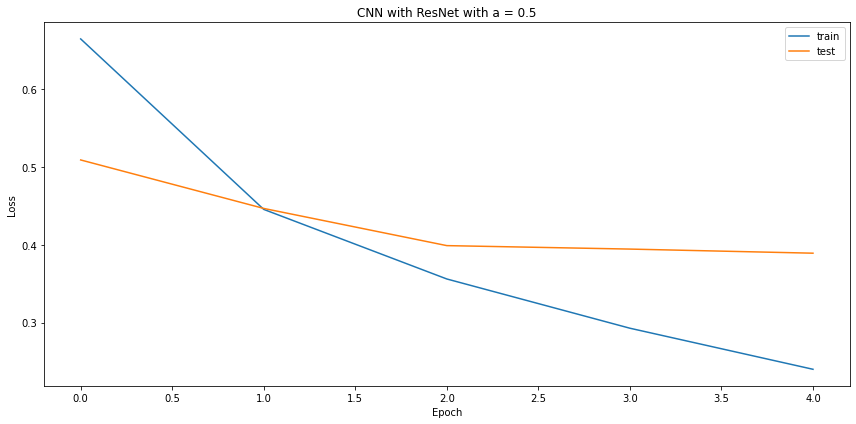

In [ ]:
show_plot(train_l, test_l, "CNN with ResNet with a = 0.5")

In [ ]:
calc_metrics(model_cnn_distillated)

Precision score: 0.75827688066049
Recall score: 0.7593000000000001
F1 score: 0.7579184842435938


In [ ]:
model_cnn_distillated_35 = CNN(32).to(device)
train_l, test_l = train(model_cnn_distillated_35, epochs=8, a_kd=0.35)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0 | Train loss 0.8266614588356018 | Test loss 0.6409145453453063
Epoch 1 | Train loss 0.5540500961494446 | Test loss 0.5445075721740723
Epoch 2 | Train loss 0.44561714522361756 | Test loss 0.5056080760002136
Epoch 3 | Train loss 0.3603413994026184 | Test loss 0.49639744901657107
Epoch 4 | Train loss 0.29615399843215945 | Test loss 0.4915713026046753
Epoch 5 | Train loss 0.23788207293510438 | Test loss 0.4962970295906067
Epoch 6 | Train loss 0.18932604990005494 | Test loss 0.5162469522476196
Epoch 7 | Train loss 0.14879248366355896 | Test loss 0.5396878715515137


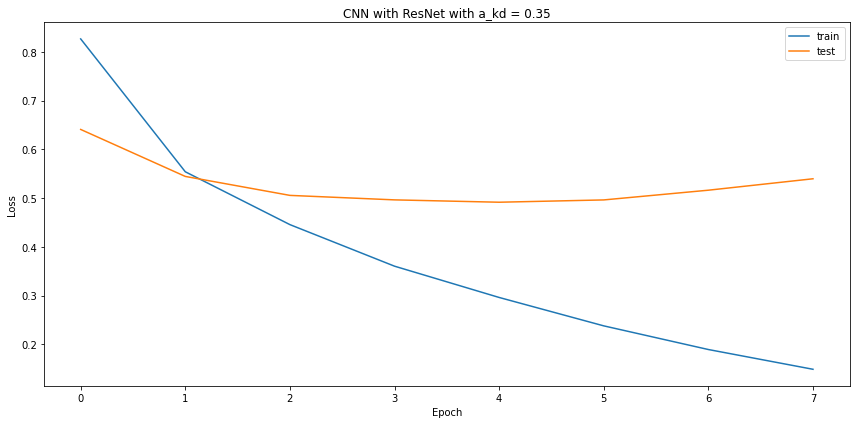

In [ ]:
show_plot(train_l, test_l, "CNN with ResNet with a_kd = 0.35")

In [ ]:
calc_metrics(model_cnn_distillated_35)

Precision score: 0.7547465195208721
Recall score: 0.7561
F1 score: 0.7552357816774281


In [ ]:
model_cnn_distillated_05 = CNN(32).to(device)
train_l, test_l = train(model_cnn_distillated_05, epochs=5, a_kd=0.05)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0 | Train loss 1.1622071011924744 | Test loss 0.8977819164276123
Epoch 1 | Train loss 0.7728341700172424 | Test loss 0.770656164932251
Epoch 2 | Train loss 0.6170721346855164 | Test loss 0.7131345410346985
Epoch 3 | Train loss 0.5050782912445069 | Test loss 0.697894810962677
Epoch 4 | Train loss 0.40769917759895324 | Test loss 0.6934109994888306


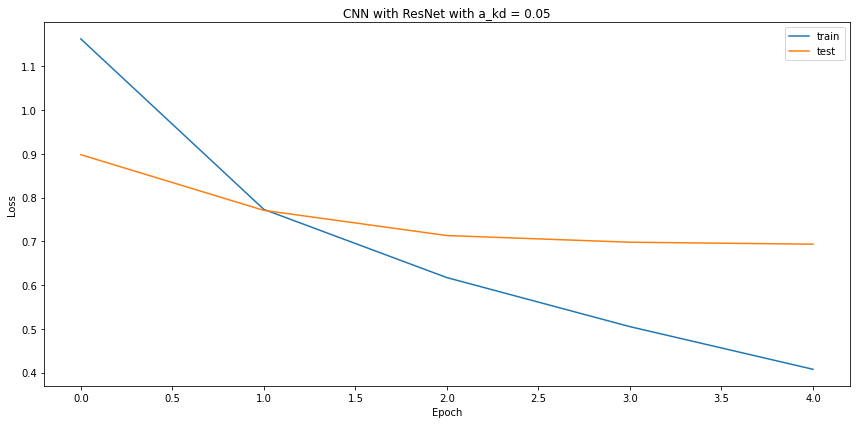

In [ ]:
show_plot(train_l, test_l, "CNN with ResNet with a_kd = 0.05")

In [ ]:
calc_metrics(model_cnn_distillated_05)

Precision score: 0.7505642292533563
Recall score: 0.751
F1 score: 0.7502687011079311


In [ ]:
model_cnn_distillated_0 = CNN(32).to(device)
train_l, test_l = train(model_cnn_distillated_0, epochs=7, a_kd=0.0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0 | Train loss 1.2573355932617187 | Test loss 0.963718132019043
Epoch 1 | Train loss 0.8265612333488465 | Test loss 0.809022774219513
Epoch 2 | Train loss 0.6657109172058105 | Test loss 0.7526410425186157
Epoch 3 | Train loss 0.5474813084602356 | Test loss 0.7152568906784058
Epoch 4 | Train loss 0.4452124604225159 | Test loss 0.7179241024971008
Epoch 5 | Train loss 0.35568619052886963 | Test loss 0.7362859698295593
Epoch 6 | Train loss 0.2803886719894409 | Test loss 0.7780546670913696


In [ ]:
calc_metrics(model_cnn_distillated_0)

Precision score: 0.7512610125796918
Recall score: 0.7507
F1 score: 0.7504148594163875


In [ ]:
# pretrained model from https://github.com/chenyaofo/pytorch-cifar-models
model_resnet_pretrained = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:
model_resnet_pretrained = model_resnet_pretrained.to(device)

In [ ]:
model_cnn_distillated_with_big_teacher = CNN(32).to(device)
train_l, test_l = train(model_cnn_distillated_with_big_teacher, epochs=5, a_kd=0.5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0 | Train loss 0.6791844213676452 | Test loss 0.5216572574615479
Epoch 1 | Train loss 0.45144612419128416 | Test loss 0.44420458393096923
Epoch 2 | Train loss 0.3620466478538513 | Test loss 0.41169017558097837
Epoch 3 | Train loss 0.29728938577651975 | Test loss 0.39662745623588563
Epoch 4 | Train loss 0.24578083671092987 | Test loss 0.4026817295074463


In [ ]:
calc_metrics(model_cnn_distillated_with_big_teacher)

Precision score: 0.7508255251733995
Recall score: 0.7501
F1 score: 0.7499017705410982
